In [4]:
%load_ext autoreload
%autoreload 2

In [4]:
!pip install scikit-image
!pip install sklearn
!pip install scipy
!pip install hdbscan
!pip install seaborn
!pip install hdbscan

You should consider upgrading via the '/Users/trevorchan/environments/machine-learning/bin/python3 -m pip install --upgrade pip' command.
  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Using cached scikit_learn-0.23.1-cp37-cp37m-macosx_10_9_x86_64.whl (7.2 MB)
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
  Using cached joblib-0.15.1-py3-none-any.whl (298 kB)
    Running setup.py install for sklearn ... done
You should consider upgrading via the '/Users/trevorchan/environments/machine-learning/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/trevorchan/environments/machine-learning/bin/python3 -m pip install --upgrade pip' command.
Processing /Users/trevorchan/Library/Caches/pip/wheels/12/bb/54/7401fdc7883b5975dba5514a185d75d7a0986472df4957637b/hdbscan-0.8.26-cp37-cp37m-macosx_10_14_x86_64.whl
  Using cached Cython-0.29.20-cp37-cp37m-macosx_10_9_x86_64.whl (1.9 MB)
You should consider upgrading via the '/Users/trevorchan/envir

In [127]:
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from PIL import Image
import torch

from tqdm import tqdm

import seaborn as sns
import pickle

import cv2
from PIL import Image

from skimage.draw import ellipse
from skimage.measure import label, regionprops, find_contours, approximate_polygon
from skimage.transform import rotate
from sklearn.neighbors import KDTree
from scipy.spatial import distance

#from sklearn.cluster import DBSCAN
import hdbscan

In [197]:
#load model output into instances dict: 
instances = {}
with open('instances.data', 'rb') as filehandle:
    instances = pickle.load(filehandle)
    
'''   "pred_boxes" "pred_masks" "scores" "classes"  "image_size" '''

'   "pred_boxes" "pred_masks" "scores" "classes"  "image_size" '

In [198]:
def make_adjacencies(instances, mindist = 50):
    #takes a list of n cell_poly objects
    #takes a minimum distance defined as adjacent
    #returns an adjacency list of length n
    
    centroid_list = []
    adjacency_list = []
    wide_list = []

    centroid_list = [ (((box[0]+box[2])/2).item() , ((box[1]+box[3])/2).item()) for box in instances["pred_boxes"] ]
    #print(len(centroid_list))
    centroid_list = np.array(centroid_list)

    polygon_list = [ np.reshape(mask[0], (int(len(mask[0])/2) , 2)) for mask in instances["pred_masks"] ]

    tree = []
    tree = KDTree(centroid_list, leaf_size=10)

    wide_list = tree.query_radius(centroid_list, mindist * 5)

    for i,small_list in tqdm(enumerate(wide_list)):
        adjacency_list.append (list())
        for index in small_list:
            # if we've already explored this pair then skip (as cdist _should_ be symmetrical)
            if index <= i:
                continue
            d = distance.cdist(polygon_list[i],polygon_list[index],'euclidean')
            if min(d.flatten()) < mindist:
                adjacency_list[i].append (index)
    
    return adjacency_list


In [199]:
centroid_list = []
adjacency_list = []
wide_list = []

centroid_list = [ (((box[0]+box[2])/2).item() , ((box[1]+box[3])/2).item()) for box in instances["pred_boxes"] ]
#print(len(centroid_list))
centroid_list = np.array(centroid_list)

polygon_list = [ np.reshape(mask[0], (int(len(mask[0])/2) , 2)) for mask in instances["pred_masks"] ]

tree = []
tree = KDTree(centroid_list, leaf_size=10)

wide_list = tree.query_radius(centroid_list, 200)

for i,small_list in tqdm(enumerate(wide_list)):
    adjacency_list.append (list())
    for index in small_list:
        # if we've already explored this pair then skip (as cdist _should_ be symmetrical)
        if index <= i:
            continue
        d = distance.cdist(polygon_list[i],polygon_list[index],'euclidean')
        if min(d.flatten()) < 50:
            adjacency_list[i].append (index)


0it [00:00, ?it/s]
2it [00:00, 10.58it/s]
4it [00:00, 11.86it/s]
6it [00:00, 11.83it/s]
8it [00:00, 12.84it/s]
11it [00:00, 15.08it/s]
14it [00:00, 17.37it/s]
17it [00:00, 18.50it/s]
20it [00:01, 18.81it/s]
22it [00:01, 18.76it/s]
25it [00:01, 20.25it/s]
28it [00:01, 21.16it/s]
31it [00:01, 23.07it/s]
34it [00:01, 21.67it/s]
37it [00:01, 22.28it/s]
41it [00:01, 24.58it/s]
44it [00:02, 25.16it/s]
47it [00:02, 25.81it/s]
51it [00:02, 28.62it/s]
55it [00:02, 29.70it/s]
59it [00:02, 30.11it/s]
63it [00:02, 29.06it/s]
68it [00:02, 31.49it/s]
73it [00:02, 34.37it/s]
77it [00:03, 32.90it/s]
83it [00:03, 37.30it/s]
88it [00:03, 37.25it/s]
94it [00:03, 40.71it/s]
117it [00:03, 32.40it/s]


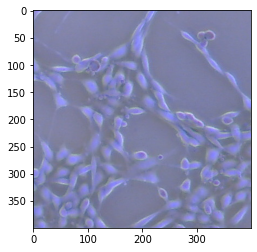

In [200]:
fig = plt.subplots()
plt.imshow(img)
#ax.add_line(lines.Line2D([centroid_list[0][0],centroid_list[1][0]], [centroid_list[0][1],centroid_list[1][1]]))
#plt.show()

In [201]:
import matplotlib.lines as lines



def plot_adjacencies(centroid_list, adjacency_list, img):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    
    
    for a,i in enumerate(adjacency_list):
        for b in i:
            plt.plot([centroid_list[a][0],centroid_list[b][0]], [centroid_list[a][1],centroid_list[b][1]], color = 'r', linewidth = .5)
    plt.show()

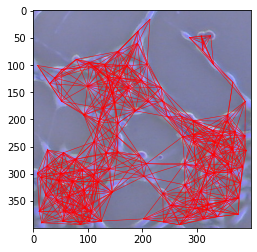

In [202]:
image_path = 'cl5-1111-tiny.JPG'
img = np.array(Image.open(image_path))

centroid_list = [ (((box[0]+box[2])/2).item() , ((box[1]+box[3])/2).item()) for box in instances["pred_boxes"] ]
#print(len(centroid_list))
centroid_list = np.array(centroid_list)

plot_adjacencies(centroid_list, adjacency_list, img)

In [203]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   ../.DS_Store
	modified:   morphological_analysis.ipynb
	modified:   updated_analysis.ipynb
	deleted:    ../morphological_analysis.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	../.ipynb_checkpoints/
	.DS_Store
	.ipynb_checkpoints/
	HighConfluencyTrain3_InProgress.png
	Untitled.ipynb
	cl5-1111-small.JPG
	cl5-1111-tiny.JPG
	instances.data
	untitled.txt

no changes added to commit (use "git add" and/or "git commit -a")
